# 训练模型的三种方法

Pytorch通常需要用户编写自定义训练循环，训练循环的代码风格因人而异。

有3类典型的训练循环代码风格：

1. 脚本形式训练循环
2. 函数形式训练循环
3. 类形式训练循环

In [1]:
# 准备数据

import torch
from torch import nn
from torchkeras import summary, Model

import torchvision
from torchvision import transforms


In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])

ds_train = torchvision.datasets.MNIST(root='./data/', train=True, download=True, transform=transform)
ds_valid = torchvision.datasets.MNIST(root='./data/', train=False, download=False, transform=transform)

dl_train = torch.utils.data.DataLoader(ds_train, batch_size=128, shuffle=True)
dl_valid = torch.utils.data.DataLoader(ds_valid, batch_size=128, shuffle=False)

print(len(ds_train))
print(len(ds_valid))

60000
10000


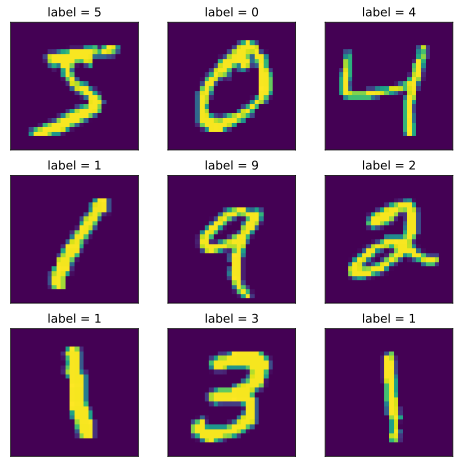

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for i in range(9):
    img, label = ds_train[i]
    img = torch.squeeze(img)
    ax = plt.subplot(3, 3, i + 1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

## 脚本风格

In [14]:
net = nn.Sequential()
net.add_module("conv1", nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3))
net.add_module("pool1", nn.MaxPool2d(kernel_size=2, stride=2))
net.add_module("conv2", nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5))
net.add_module("pool2", nn.MaxPool2d(kernel_size=2, stride=2))
net.add_module("dropout", nn.Dropout2d(p=0.1))
net.add_module("adaptive_pool", nn.AdaptiveMaxPool2d((1, 1)))
net.add_module("flatten", nn.Flatten())
net.add_module("linear1", nn.Linear(64, 32))
net.add_module("relu", nn.ReLU())
net.add_module("linear2", nn.Linear(32, 10))

print(net)

Sequential(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.1, inplace=False)
  (adaptive_pool): AdaptiveMaxPool2d(output_size=(1, 1))
  (flatten): Flatten()
  (linear1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)


In [15]:
summary(net, input_shape=(1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             320
         MaxPool2d-2           [-1, 32, 15, 15]               0
            Conv2d-3           [-1, 64, 11, 11]          51,264
         MaxPool2d-4             [-1, 64, 5, 5]               0
         Dropout2d-5             [-1, 64, 5, 5]               0
 AdaptiveMaxPool2d-6             [-1, 64, 1, 1]               0
           Flatten-7                   [-1, 64]               0
            Linear-8                   [-1, 32]           2,080
              ReLU-9                   [-1, 32]               0
           Linear-10                   [-1, 10]             330
Total params: 53,994
Trainable params: 53,994
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.003906
Forward/backward pass size (MB): 0.359695
Params size (MB): 0.205971
E

In [17]:
import datetime
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

def accuracy(y_pred,y_true):
    y_pred_cls = torch.argmax(nn.Softmax(dim=1)(y_pred), dim=1).data
    return accuracy_score(y_true, y_pred_cls)

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=net.parameters(),lr = 0.01)
metric_func = accuracy
metric_name = "accuracy"

In [19]:
epochs = 3
log_step_freq = 100

df_history = pd.DataFrame(columns = ["epoch", "loss", metric_name, "val_loss", "val_"+metric_name])
print("Start Training...")
nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print("=========="*8 + "%s"%nowtime)

for epoch in range(epochs):

    # 1，训练循环-------------------------------------------------
    net.train()
    loss_sum = 0.0
    metric_sum = 0.0
    step = 1

    for step, (features,labels) in enumerate(dl_train, 1):
        # 梯度清零
        optimizer.zero_grad()

        # 正向传播求损失
        pred = net(features)
        loss = loss_func(pred, labels)
        metric = metric_func(pred, labels)

        # 反向传播求梯度
        loss.backward()
        optimizer.step()

        # 打印batch级别日志
        loss_sum += loss.item()
        metric_sum += metric.item()
        if step%log_step_freq == 0:
            print(("[step = %d] loss: %.3f, " + metric_name + ": %.3f") %
                  (step, loss_sum/step, metric_sum/step))

    # 2，验证循环-------------------------------------------------
    net.eval()
    val_loss_sum = 0.0
    val_metric_sum = 0.0
    val_step = 1

    for val_step, (features,labels) in enumerate(dl_valid, 1):
        with torch.no_grad():
            pred = net(features)
            val_loss = loss_func(pred, labels)
            val_metric = metric_func(pred, labels)

        val_loss_sum += val_loss.item()
        val_metric_sum += val_metric.item()

    # 3，记录日志-------------------------------------------------
    info = (epoch, loss_sum/step, metric_sum/step,
            val_loss_sum/val_step, val_metric_sum/val_step)
    df_history.loc[epoch-1] = info

    # 打印epoch级别日志
    print(("\nEPOCH = %d, loss = %.3f,"+ metric_name + \
          "  = %.3f, val_loss = %.3f, "+"val_"+ metric_name+" = %.3f")
          %info)
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)
print('Finished Training...')

Start Training...
================================================================================2021-02-12 16:00:55
[step = 100] loss: 0.079, accuracy: 0.975
[step = 200] loss: 0.074, accuracy: 0.977
[step = 300] loss: 0.076, accuracy: 0.977
[step = 400] loss: 0.079, accuracy: 0.976

EPOCH = 0, loss = 0.078,accuracy  = 0.977, val_loss = 0.072, val_accuracy = 0.977

================================================================================2021-02-12 16:01:20
[step = 100] loss: 0.085, accuracy: 0.975
[step = 200] loss: 0.079, accuracy: 0.977
[step = 300] loss: 0.079, accuracy: 0.977
[step = 400] loss: 0.081, accuracy: 0.976

EPOCH = 1, loss = 0.083,accuracy  = 0.976, val_loss = 0.084, val_accuracy = 0.977

================================================================================2021-02-12 16:01:47
[step = 100] loss: 0.066, accuracy: 0.979
[step = 200] loss: 0.066, accuracy: 0.979
[step = 300] loss: 0.075, accuracy: 0.977
[step = 400] loss: 0.079, accuracy: 0.976

EPOCH = 2

## 函数风格

In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
            nn.MaxPool2d(kernel_size=2, stride = 2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.1),
            nn.AdaptiveMaxPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

net = Net()
print(net)

Net(
  (layers): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.1, inplace=False)
    (5): AdaptiveMaxPool2d(output_size=(1, 1))
    (6): Flatten()
    (7): Linear(in_features=64, out_features=32, bias=True)
    (8): ReLU()
    (9): Linear(in_features=32, out_features=10, bias=True)
  )
)


In [21]:
summary(net, input_shape=(1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             320
         MaxPool2d-2           [-1, 32, 15, 15]               0
            Conv2d-3           [-1, 64, 11, 11]          51,264
         MaxPool2d-4             [-1, 64, 5, 5]               0
         Dropout2d-5             [-1, 64, 5, 5]               0
 AdaptiveMaxPool2d-6             [-1, 64, 1, 1]               0
           Flatten-7                   [-1, 64]               0
            Linear-8                   [-1, 32]           2,080
              ReLU-9                   [-1, 32]               0
           Linear-10                   [-1, 10]             330
Total params: 53,994
Trainable params: 53,994
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.003906
Forward/backward pass size (MB): 0.359695
Params size (MB): 0.205971
E

In [22]:
import datetime
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

def accuracy(y_pred,y_true):
    y_pred_cls = torch.argmax(nn.Softmax(dim=1)(y_pred), dim=1).data
    return accuracy_score(y_true, y_pred_cls)

model = net
model.optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
model.loss_func = nn.CrossEntropyLoss()
model.metric_func = accuracy
model.metric_name = "accuracy"

In [23]:
def train_step(model, features, labels):
    # 训练模式
    model.train()
    # 梯度清零
    model.optimizer.zero_grad()
    # 正向传播求损失
    pred = model(features)
    loss = model.loss_func(pred, labels)
    metric = model.metric_func(pred, labels)
    # 反向传播求梯度
    loss.backward()
    model.optimizer.step()
    return loss.item(), metric.item()

@torch.no_grad()
def valid_step(model, features, labels):
    # 预测模式
    model.eval()
    pred = model(features)
    loss = model.loss_func(pred, labels)
    metric = model.metric_func(pred, labels)
    return loss.item(), metric.item()

# 测试train_step效果
features, labels = next(iter(dl_train))
train_step(model,features,labels)

(2.302320718765259, 0.1015625)

In [24]:
def train_model(model, epochs, dl_train, dl_valid, log_step_freq):
    metric_name = model.metric_name
    df_history = pd.DataFrame(columns=["epoch", "loss", metric_name, "val_loss", "val_" + metric_name])
    print("Start Training...")
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("=========="*8 + "%s"%nowtime)
    for epoch in range(1, epochs + 1):
        # 1，训练循环-------------------------------------------------
        loss_sum = 0.0
        metric_sum = 0.0
        step = 1

        for step, (features, labels) in enumerate(dl_train, 1):
            loss, metric = train_step(model, features, labels)
            loss_sum += loss
            metric_sum += metric
            if step%log_step_freq == 0:
                print(("[step = %d] loss: %.3f, "+metric_name+": %.3f") %
                      (step, loss_sum/step, metric_sum/step))
        # 2，验证循环-------------------------------------------------
        val_loss_sum = 0.0
        val_metric_sum = 0.0
        val_step = 1

        for val_step, (features, labels) in enumerate(dl_valid, 1):
            val_loss, val_metric = valid_step(model, features, labels)
            val_loss_sum += val_loss
            val_metric_sum += val_metric

        # 3，记录日志-------------------------------------------------
        info = (epoch, loss_sum / step, metric_sum / step,
                val_loss_sum / val_step, val_metric_sum / val_step)
        df_history.loc[epoch-1] = info

        # 打印epoch级别日志
        print(("\nEPOCH = %d, loss = %.3f,"+ metric_name + \
              "  = %.3f, val_loss = %.3f, "+"val_"+ metric_name+" = %.3f")
              %info)
        nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        print("\n"+"=========="*8 + "%s"%nowtime)

    print('Finished Training...')
    return df_history

In [25]:
epochs = 3
dfhistory = train_model(model, epochs, dl_train, dl_valid, log_step_freq = 100)

Start Training...
================================================================================2021-02-12 16:16:47
[step = 100] loss: 2.298, accuracy: 0.102
[step = 200] loss: 2.288, accuracy: 0.112
[step = 300] loss: 2.275, accuracy: 0.145
[step = 400] loss: 2.260, accuracy: 0.185

EPOCH = 1, loss = 2.248,accuracy  = 0.212, val_loss = 2.143, val_accuracy = 0.464

================================================================================2021-02-12 16:17:13
[step = 100] loss: 2.112, accuracy: 0.417
[step = 200] loss: 2.056, accuracy: 0.434
[step = 300] loss: 1.986, accuracy: 0.453
[step = 400] loss: 1.903, accuracy: 0.475

EPOCH = 2, loss = 1.842,accuracy  = 0.491, val_loss = 1.340, val_accuracy = 0.736

================================================================================2021-02-12 16:17:39
[step = 100] loss: 1.320, accuracy: 0.626
[step = 200] loss: 1.231, accuracy: 0.652
[step = 300] loss: 1.147, accuracy: 0.676
[step = 400] loss: 1.070, accuracy: 0.700

EPOCH = 3

## 类风格

In [29]:
from torchkeras import Model

class Net(Model):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
            nn.MaxPool2d(kernel_size=2, stride = 2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.1),
            nn.AdaptiveMaxPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10)
        ])

    def forward(self,x):
        for layer in self.layers:
            x = layer(x)
        return x

model = Net()
print(model)

Net(
  (layers): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.1, inplace=False)
    (5): AdaptiveMaxPool2d(output_size=(1, 1))
    (6): Flatten()
    (7): Linear(in_features=64, out_features=32, bias=True)
    (8): ReLU()
    (9): Linear(in_features=32, out_features=10, bias=True)
  )
)


In [30]:
model.summary(input_shape=(1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             320
         MaxPool2d-2           [-1, 32, 15, 15]               0
            Conv2d-3           [-1, 64, 11, 11]          51,264
         MaxPool2d-4             [-1, 64, 5, 5]               0
         Dropout2d-5             [-1, 64, 5, 5]               0
 AdaptiveMaxPool2d-6             [-1, 64, 1, 1]               0
           Flatten-7                   [-1, 64]               0
            Linear-8                   [-1, 32]           2,080
              ReLU-9                   [-1, 32]               0
           Linear-10                   [-1, 10]             330
Total params: 53,994
Trainable params: 53,994
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.003906
Forward/backward pass size (MB): 0.359695
Params size (MB): 0.205971
E

In [32]:
import datetime
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

def accuracy(y_pred,y_true):
    y_pred_cls = torch.argmax(nn.Softmax(dim=1)(y_pred), dim=1).data
    return accuracy_score(y_true, y_pred_cls)

model.compile(loss_func=nn.CrossEntropyLoss(),
              optimizer=torch.optim.Adam(model.parameters(), lr=0.02),
              metrics_dict={'accuracy' : accuracy})

In [33]:
df_history = model.fit(epochs=3, dl_train=dl_train, dl_val=dl_valid, log_step_freq=100)

Start Training ...

================================================================================2021-02-12 16:27:58
{'step': 100, 'loss': 0.99, 'accuracy': 0.656}
{'step': 200, 'loss': 0.637, 'accuracy': 0.786}
{'step': 300, 'loss': 0.493, 'accuracy': 0.836}
{'step': 400, 'loss': 0.411, 'accuracy': 0.865}

 +-------+-------+----------+----------+--------------+
| epoch |  loss | accuracy | val_loss | val_accuracy |
+-------+-------+----------+----------+--------------+
|   1   | 0.375 |  0.878   |  0.118   |    0.966     |
+-------+-------+----------+----------+--------------+

================================================================================2021-02-12 16:28:23
{'step': 100, 'loss': 0.174, 'accuracy': 0.949}
{'step': 200, 'loss': 0.169, 'accuracy': 0.95}
{'step': 300, 'loss': 0.173, 'accuracy': 0.949}
{'step': 400, 'loss': 0.176, 'accuracy': 0.949}

 +-------+-------+----------+----------+--------------+
| epoch |  loss | accuracy | val_loss | val_accuracy |
+-------